In [1]:
# !pip install tensorflow
# !pip install keras

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
class TextAnalysis(object):
      def __init__(self):
          self.messages = pd.read_csv('/content/sample_data/spam.csv', encoding='latin-1')
          self.messages = self.messages.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
          self.stopwordsList = list(stopwords.words("english"))
          self.punctuation = string.punctuation
          self.messages['label'] = np.where(self.messages['label'] == 'spam',1,0)

      # func to clean the text...
      def cleanText(self, text):
          # Remove the punctuations....
          text = "".join([word.lower() for word in text if word not in self.punctuation])
          # Tokenize our text...
          tokens = word_tokenize(text)
          text = [word for word in tokens if word not in self.stopwordsList]
          return text

      # Split the dataset..
      def splitData(self):
          # Split the dataset into train and test...
          X_train, X_test, y_train, y_test = train_test_split(self.messages['clean_text'], 
                                                              self.messages['label'],
                                                              test_size=0.2)
          
          return X_train, X_test, y_train, y_test

         

In [44]:
# Create an object of Text Analysis...
obj_ta = TextAnalysis()

In [45]:
obj_ta.messages.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [46]:
# Perform text Cleaning using the lambda function...
obj_ta.messages['clean_text'] = obj_ta.messages['text'].apply(lambda x: obj_ta.cleanText(x))

In [47]:
obj_ta.messages.head()

,label,text,clean_text
0,0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,0,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t..."


In [48]:
# get the train and test datasets after the split...
X_train, X_test, y_train, y_test = obj_ta.splitData()

In [50]:
# How do the first 10 messages of the train and test data look like...
X_train[:]

4930    [good, morning, boytoy, hows, yummy, lips, whe...
964                                          [much, buzy]
1833                                               [come]
378                         [keep, payasam, rinu, brings]
3484    [noi, got, rumour, going, buy, apartment, chen...
                              ...                        
3165    [hot, live, fantasies, call, 08707509020, 20p,...
651     [im, gon, na, say, sorry, would, normal, start...
1513                      [hows, champ, leaving, glasgow]
4420    [still, west, coast, haiz, ìïll, take, forever...
4899    [ou, guaranteed, latest, nokia, phone, 40gb, i...
Name: clean_text, Length: 4457, dtype: object

In [51]:
X_test[:]

5020                                  [sad, puppy, noise]
4257                                               [late]
2055                                 [sir, waiting, mail]
4416    [says, hes, quitting, least5times, day, wudnt,...
2188    [free, camera, phones, linerental, 449month, 7...
                              ...                        
4267                              [hey, whats, plan, sat]
1433              [intrepid, duo, great, time, see, soon]
602                                 [speaking, cash, yet]
3335                           [u, go, back, urself, lor]
4463     [ranjith, cal, drpd, deeraj, deepak, 5min, hold]
Name: clean_text, Length: 1115, dtype: object

In [52]:
# How do the labels look like
y_train[:10]

4930    0
964     0
1833    0
378     0
3484    0
269     1
3200    0
1693    0
5503    0
1855    0
Name: label, dtype: int64

In [54]:
# Lets save the train and test data to ensure that we use the same datasets for different ML/DL techniques
X_train.to_csv('/content/sample_data/X_train.csv', index=False, header=True)
X_test.to_csv('/content/sample_data/X_test.csv',index=False, header=True)
y_train.to_csv('/content/sample_data/y_train.csv',index=False, header=True)
y_test.to_csv('/content/sample_data/y_test.csv',index=False, header=True)


## Build Models on TF-IDF Vectors

In [55]:
# Read the Train and Test data...
X_train = pd.read_csv("/content/sample_data/X_train.csv")
y_train = pd.read_csv('/content/sample_data/y_train.csv')
X_test = pd.read_csv("/content/sample_data/X_test.csv")
y_test = pd.read_csv('/content/sample_data/y_test.csv')

In [56]:
# print the training data...
X_train.head()

,clean_text
0,"['good', 'morning', 'boytoy', 'hows', 'yummy',..."
1,"['much', 'buzy']"
2,['come']
3,"['keep', 'payasam', 'rinu', 'brings']"
4,"['noi', 'got', 'rumour', 'going', 'buy', 'apar..."


In [57]:
# print the test data
X_test.head()

,clean_text
0,"['sad', 'puppy', 'noise']"
1,['late']
2,"['sir', 'waiting', 'mail']"
3,"['says', 'hes', 'quitting', 'least5times', 'da..."
4,"['free', 'camera', 'phones', 'linerental', '44..."


In [59]:
# Instantiate the TF-IDF Vectorizer...
tfidfVect = TfidfVectorizer()
tfidfVect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [63]:
# fit the tfidf part...
tfidfVect.fit(X_train['clean_text'])
print("Vocabulary of the Dataset is : ")
print(tfidfVect.vocabulary_)

Vocabulary of the Dataset is : 
{'good': 3363, 'morning': 4896, 'boytoy': 1571, 'hows': 3726, 'yummy': 8272, 'lips': 4405, 'wheres': 7948, 'sexy': 6430, 'buns': 1660, 'think': 7273, 'crave': 2192, 'need': 5031, 'much': 4944, 'buzy': 1683, 'come': 2024, 'keep': 4135, 'payasam': 5461, 'rinu': 6161, 'brings': 1608, 'noi': 5120, 'got': 3385, 'rumour': 6225, 'going': 3350, 'buy': 1679, 'apartment': 1095, 'chennai': 1886, 'ringtone': 6157, 'club': 1978, 'get': 3287, 'uk': 7570, 'singles': 6572, 'chart': 1857, 'mobile': 4850, 'week': 7895, 'choose': 1927, 'top': 7423, 'quality': 5890, 'message': 4752, 'free': 3139, 'charge': 1851, 'nicenicehow': 5075, 'working': 8052, 'gr8': 3395, 'see': 6364, 'leaving': 4319, 'congrats': 2089, 'dear': 2338, 'school': 6320, 'wat': 7850, 'ur': 7649, 'plans': 5583, 'perhaps': 5494, 'easy': 2671, 'give': 3316, 'account': 856, 'identification': 3805, 'tomorrow': 7397, 'uni': 7603, 'kyou': 4233, 'girl': 3309, 'waiting': 7806, 'reception': 6001, 'ah': 947, 'one': 5

In [64]:
# Perform tfidf on train and test dataset to create a sparse matrix...
X_train_vect = tfidfVect.transform(X_train['clean_text'])
X_test_vect = tfidfVect.transform(X_test['clean_text'])

In [70]:
# How are these vectors stored...
print("Sparse Matrix of the Training data...")
X_train_vect[0]

Sparse Matrix of the Training data...


<1x8295 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [71]:
print("Sparse Matrix of the Testing data...")
X_test_vect[0]

Sparse Matrix of the Testing data...


<1x8295 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [72]:
# Can we convert these vectors to arrays...
X_test_vect[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [77]:
# Instantiate the RandomForest Classifier...
modelRF = RandomForestClassifier()
modelRF

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [79]:
# Fit it into the train set
modelRF_fit = modelRF.fit(X_train_vect, y_train.values.ravel())
modelRF_fit

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [81]:
y_pred = modelRF_fit.predict(X_test_vect)

In [87]:
# Evaluate the performance of the model on the unseen text data...
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)

print('Accuracy : {} / Precision : {} / Recall : {} / F1-Score : {}'.format(accuracy, precision, recall, f1_score))

Accuracy : 0.9695067264573991 / Precision : 1.0 / Recall : 0.7553956834532374 / F1-Score : 0.860655737704918


In [90]:
# get the Clssification report...
print("Classification Report is : ")
print(classification_report(y_test, y_pred))

Classification Report is : 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       976
           1       1.00      0.76      0.86       139

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115



## Create Word2Vec Models

In [92]:
# Train a basic word2vec model...
model_w2v = Word2Vec(X_train, size=100, 
                     window=5, min_count=2)

In [95]:
model_w2v

In [105]:
# Replace the words in each text with their appropriate Word2Vec model...
words = set(model_w2v.wv.index2word)
X_train_w2v_vect = np.array([np.array([model_w2v.wv[i] for i in ls if i in words])
                             for ls in X_train['clean_text']])

# Create Word vectors for the test set...
X_test_w2v_vect = np.array([np.array([model_w2v.wv[i] for i in ls if i in words])
                             for ls in X_test['clean_text']])

In [107]:
print("Length of the Word2Vec vectors are : ")
print(len(X_train_w2v_vect))
print()
print("The vectors for first word are : ")
print(X_train_w2v_vect[0][0])
print()
print("Length of the Word2Vect test vectors are : ")
print(len(X_test_w2v_vect))
print()
print("The vectors for the first word are : ")
print(X_test_w2v_vect[0][0])

Length of the Word2Vec vectors are : 
4457

The vectors for first word are : 
[ 0.00396732 -0.00328892  0.00370869 -0.00305372 -0.00270917  0.00237351
  0.00405673 -0.00280194  0.00264076 -0.00297807 -0.00289587 -0.00362911
 -0.00014753  0.00167454  0.0001826   0.00087488 -0.0045652   0.0035915
  0.00245221  0.00160005  0.00112918  0.00257055  0.00012684  0.00214202
  0.0004434  -0.00479697  0.00273362 -0.00374223  0.00377407  0.00361084
 -0.00431967 -0.00160431 -0.00123606 -0.00307783 -0.00477444 -0.00343499
 -0.00341241 -0.00196227 -0.00462878  0.00228309 -0.00482763 -0.00401682
  0.00461745 -0.00214594 -0.00470943  0.00062895 -0.00313762 -0.00188191
 -0.00383911 -0.00070366  0.00376175 -0.0010646  -0.00037402  0.00381775
 -0.0026288   0.00108672 -0.00014367 -0.00357763 -0.0021635   0.00331943
  0.00379137  0.0013573  -0.000731    0.00269206 -0.00094731 -0.00489419
 -0.00360579 -0.00349347  0.00144218  0.00263324 -0.003264    0.0034466
  0.00112027 -0.00474528  0.00374748  0.00230701

In [110]:
# Average the word vectors for each text message to get a single vector representation of each length..
X_train_w2v_vect_avg = []
for vec in X_train_w2v_vect:
    if vec.size:
       X_train_w2v_vect_avg.append(vec.mean(axis=0))
    else:
       X_train_w2v_vect_avg.append(np.zeros(100, dtype=float))
    
X_test_w2v_vect_avg = []
for vec in X_test_w2v_vect:
    if vec.size:
       X_test_w2v_vect_avg.append(vec.mean(axis=0))
    else:
       X_test_w2v_vect_avg.append(np.zeros(100, dtype=float))


In [111]:
# Unaveraged version...
X_train_w2v_vect[0]

array([[ 3.9673205e-03, -3.2889210e-03,  3.7086927e-03, -3.0537243e-03,
        -2.7091699e-03,  2.3735124e-03,  4.0567252e-03, -2.8019396e-03,
         2.6407621e-03, -2.9780688e-03, -2.8958677e-03, -3.6291122e-03,
        -1.4753372e-04,  1.6745386e-03,  1.8259943e-04,  8.7488414e-04,
        -4.5652045e-03,  3.5915005e-03,  2.4522089e-03,  1.6000535e-03,
         1.1291822e-03,  2.5705537e-03,  1.2683877e-04,  2.1420228e-03,
         4.4339529e-04, -4.7969706e-03,  2.7336217e-03, -3.7422336e-03,
         3.7740713e-03,  3.6108363e-03, -4.3196674e-03, -1.6043123e-03,
        -1.2360616e-03, -3.0778258e-03, -4.7744447e-03, -3.4349938e-03,
        -3.4124071e-03, -1.9622743e-03, -4.6287780e-03,  2.2830863e-03,
        -4.8276251e-03, -4.0168175e-03,  4.6174549e-03, -2.1459446e-03,
        -4.7094305e-03,  6.2895002e-04, -3.1376162e-03, -1.8819101e-03,
        -3.8391091e-03, -7.0365664e-04,  3.7617502e-03, -1.0646011e-03,
        -3.7402139e-04,  3.8177450e-03, -2.6287993e-03,  1.08671

In [112]:
# Averaged Version..
X_test_w2v_vect_avg[0]

array([-2.3693284e-03,  2.2285266e-03, -4.1085994e-03,  4.1090599e-03,
       -4.9084336e-03, -4.4520437e-03, -7.6832552e-04, -4.2574611e-03,
       -3.9410987e-03,  4.3579889e-03,  3.5380849e-03,  2.2129747e-03,
       -3.4099277e-03, -1.1596387e-03,  1.7859827e-03,  1.7129338e-03,
        1.5721625e-03, -8.4641259e-05,  2.7348511e-03,  2.7310285e-03,
       -4.1742590e-03,  1.9250037e-03, -2.5602735e-03,  3.0311462e-03,
        3.9379639e-03, -3.6657569e-03,  2.7489793e-03,  4.0378203e-04,
       -3.3104357e-03,  3.9881645e-03, -1.5149956e-03, -2.2975327e-03,
       -4.8651332e-03,  2.9817019e-03,  3.0816193e-03, -1.2428636e-03,
       -4.0632905e-03, -2.2435498e-03, -8.1594172e-04, -8.8319846e-04,
        2.4549554e-03, -4.7665336e-03, -5.6421640e-04, -4.0153582e-03,
       -4.3552327e-03, -2.8783231e-04,  3.7691221e-03, -4.6495590e-03,
        1.7347686e-03, -9.9130697e-04, -4.5631863e-03, -2.2064282e-03,
        4.8391568e-03, -1.1156721e-03, -5.4961775e-04,  2.6602987e-03,
      

## Fit a RandomForest Model on top of Word2Vec vectors

In [113]:
model_rf_w2v = RandomForestClassifier()

In [114]:
model_rf_w2v

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [115]:
# Fit the model
model_rf_w2v = model_rf_w2v.fit(X_train_w2v_vect_avg, y_train.values.ravel())

In [116]:
# perform predictions on the test set...
y_pred = model_rf_w2v.predict(X_test_w2v_vect_avg)

In [124]:
# Evaluate the model...
accuracy_w2v = accuracy_score(y_test, y_pred)
precision_w2v = precision_score(y_test, y_pred)
recall_w2v = recall_score(y_test, y_pred)

print('Accuracy : {} / Precision : {} / Recall : {}'.format(accuracy_w2v, precision_w2v, recall_w2v))

Accuracy : 0.8780269058295964 / Precision : 0.5194805194805194 / Recall : 0.28776978417266186


In [125]:
print("Classification Report is : ")
print(classification_report(y_test, y_pred))

Classification Report is : 
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       976
           1       0.52      0.29      0.37       139

    accuracy                           0.88      1115
   macro avg       0.71      0.62      0.65      1115
weighted avg       0.86      0.88      0.86      1115



## Using Doc2Vec on the Words

In [131]:
# Create TaggedDocument vectors for each text message...
tagged_docs_train = [TaggedDocument(value, [index])
                     for index,value in enumerate(X_train['clean_text'])]

tagged_docs_test = [TaggedDocument(value, [index])
                    for index,value in enumerate(X_test['clean_text'])]


In [134]:
print("Tagged Documents train : ")
print(tagged_docs_train[0])
print()
print("Tagged Documents test : ")
print(tagged_docs_test[0])

Tagged Documents train : 
TaggedDocument(['good', 'morning', 'boytoy', 'hows', 'yummy', 'lips', 'wheres', 'sexy', 'buns', 'think', 'crave', 'need'], [0])

Tagged Documents test : 
TaggedDocument(['sad', 'puppy', 'noise'], [0])


In [135]:
# Create a basic Doc2Vec Model...
model_d2v = Doc2Vec(tagged_docs_train,
                    vector_size=100,
                    window=5,
                    min_count=2)

In [136]:
model_d2v

In [138]:
# Infer the vectors used for training and testing...
train_vectors = [model_d2v.infer_vector(eval(v.words)) for v in tagged_docs_train]
test_vectors = [model_d2v.infer_vector(eval(v.words)) for v in tagged_docs_test]

In [140]:
train_vectors[0]

array([-6.4364285e-04,  4.6261074e-03,  1.8556172e-03,  4.8709996e-03,
       -1.8496261e-03,  3.2621963e-04,  4.9107512e-03, -8.0680847e-04,
       -4.7761663e-03,  9.4222679e-04,  3.1384919e-03,  1.6797542e-03,
       -1.2730603e-03,  1.2740277e-03, -4.9537127e-03,  4.2067636e-03,
        3.0988716e-03,  2.8859929e-03,  4.3520066e-03,  5.6504534e-04,
        2.6557685e-04,  1.1517146e-03, -5.4195814e-05, -4.2654998e-03,
       -2.0437439e-03,  4.8320037e-03, -4.1040825e-04,  3.8081161e-03,
        2.9249690e-04, -3.4781304e-04, -4.1545681e-03,  3.6903878e-03,
        1.2648649e-03, -7.2829227e-04,  1.0390483e-03, -2.1225230e-03,
        4.2112055e-03,  2.0421813e-04, -2.3046290e-04, -4.5832484e-03,
        1.0644912e-03, -2.4461460e-03, -2.3601397e-03,  3.9623007e-03,
        3.1569437e-03,  2.3533644e-03,  1.2258058e-05, -4.5949887e-03,
       -7.0610322e-04,  2.0112523e-03, -1.6218674e-03,  3.9145602e-03,
        3.8287069e-03,  4.6158242e-03,  4.4189123e-03, -1.8944913e-03,
      

In [141]:
test_vectors[0]

array([ 2.6803371e-03,  4.0571289e-03,  1.8364345e-03,  2.8927259e-03,
       -3.0633351e-03, -2.1365611e-03, -4.3111076e-03, -3.3641793e-03,
        3.8131853e-03,  1.7676924e-03,  2.6718280e-03, -4.3055774e-03,
        4.6137325e-03,  2.1877398e-03, -4.5160777e-03, -8.0592639e-05,
        4.9405498e-03, -4.7513116e-03,  2.2956766e-03,  7.0199365e-04,
        2.9530334e-03, -4.4074324e-03, -4.9090702e-03,  4.3267943e-04,
        2.8475688e-03, -3.2575985e-03,  1.3199277e-03,  3.5476277e-03,
        1.0746232e-04, -2.6160993e-03, -2.2112462e-03,  2.9191053e-03,
       -4.8404536e-03, -2.4673119e-03,  3.6368240e-03,  3.6988275e-03,
        1.7806542e-03,  4.4657290e-03,  3.4703305e-03,  8.5895485e-04,
        3.5401206e-03,  7.2058354e-04, -2.6125482e-03, -3.0131091e-03,
        3.0105370e-03,  3.4251250e-03, -1.5736334e-03, -3.3672235e-03,
        1.4802187e-03,  3.2815062e-03, -1.0033885e-03, -1.6034199e-03,
        4.4735004e-03, -3.8330903e-04,  2.6824910e-03, -4.7764978e-03,
      

## Fit a RandomForest Model on the Doc2Vec Vectors

In [142]:
model_rf_d2v = RandomForestClassifier()

In [143]:
model_rf_d2v

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [144]:
# Fit the model...
model_rf_d2v = model_rf_d2v.fit(train_vectors, y_train.values.ravel())

In [145]:
# Perform Predictions on the testset..
y_pred = model_rf_d2v.predict(test_vectors)

In [146]:
# Evaluate the model...
accuracy_d2v = accuracy_score(y_test, y_pred)
precision_d2v = precision_score(y_test, y_pred)
recall_d2v = recall_score(y_test, y_pred)

print('Accuracy : {} / Precision : {} / Recall : {}'.format(accuracy_d2v, precision_d2v, recall_d2v))

Accuracy : 0.8923766816143498 / Precision : 0.88 / Recall : 0.15827338129496402


In [147]:
print("The Classification Report is : ")
print(classification_report(y_test, y_pred))

The Classification Report is : 
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       976
           1       0.88      0.16      0.27       139

    accuracy                           0.89      1115
   macro avg       0.89      0.58      0.61      1115
weighted avg       0.89      0.89      0.86      1115



## Build an RNN Model..

In [148]:
# Train the tokenizer and use the tokenizer to convert the words into sequence of numbers...
tokenizer = Tokenizer()

In [149]:
tokenizer.fit_on_texts(X_train['clean_text'])
X_train_seq = tokenizer.texts_to_sequences(X_train['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['clean_text'])

In [150]:
# Pad the sequence of words to optimize them to fixed length...
X_train_seq_padded = pad_sequences(X_train_seq, 50)
X_test_seq_padded = pad_sequences(X_test_seq, 50)

### Build and evaluate RNN

In [153]:
# Prepare the model metrics...
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true,0,1)))
    recall_score = true_positives / (possible_positives + K.epsilon())

    return recall_score

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_true,0,1)))
    precision_score = true_positives / (predicted_positives + K.epsilon())

    return precision_score


In [154]:
# Construct a Simple RNN Model
model_rnn = Sequential()
model_rnn

In [155]:
# create different types of Embeddings...
model_rnn.add(Embedding(len(tokenizer.index_word)+1, 32))
model_rnn.add(LSTM(32, dropout=0, recurrent_dropout=0))
model_rnn.add(Dense(32, activation='relu'))
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          267136    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 276,545
Trainable params: 276,545
Non-trainable params: 0
_________________________________________________________________


In [156]:
# Compile the model...
model_rnn.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics = ['accuracy', precision_m, recall_m])

In [158]:
# Fit the RNN model
model_history = model_rnn.fit(X_train_seq_padded, y_train['label'],
                              batch_size=32, epochs=10,
                              validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 25s 34ms/step - loss: 0.4074 - accuracy: 0.8689 - precision_m: 0.0989 - recall_m: 0.0989 - val_loss: 0.0874 - val_accuracy: 0.9830 - val_precision_m: 0.8831 - val_recall_m: 0.8831
Epoch 2/10
140/140 [==============================] - 4s 27ms/step - loss: 0.0398 - accuracy: 0.9924 - precision_m: 0.9355 - recall_m: 0.9355 - val_loss: 0.0674 - val_accuracy: 0.9794 - val_precision_m: 0.8738 - val_recall_m: 0.8738
Epoch 3/10
140/140 [==============================] - 4s 27ms/step - loss: 0.0090 - accuracy: 0.9981 - precision_m: 0.9900 - recall_m: 0.9900 - val_loss: 0.0710 - val_accuracy: 0.9812 - val_precision_m: 0.8928 - val_recall_m: 0.8928
Epoch 4/10
140/140 [==============================] - 4s 27ms/step - loss: 0.0029 - accuracy: 0.9996 - precision_m: 0.9867 - recall_m: 0.9867 - val_loss: 0.0900 - val_accuracy: 0.9812 - val_precision_m: 0.9023 - val_recall_m: 0.9023
Epoch 5/10
140/140 [==============================] - 4s 27ms/step 

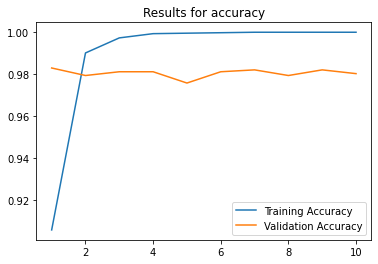

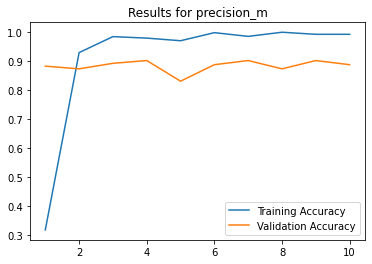

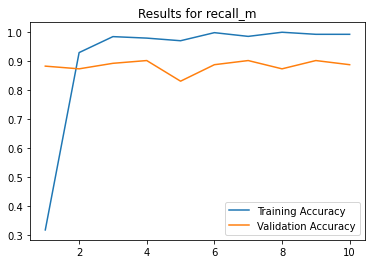

In [159]:
# Plot the evaluation metrics for each epoch of the model to check the model performance...
for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = model_history.history[i]
    val_acc = model_history.history['val_{}'.format(i)]
    epochs = range(1, len(acc)+1)

    # plot the graphs...
    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title("Results for {}".format(i))
    plt.legend()
    plt.show()

### Compare the Metrics of all the models

In [161]:
metrics_df = pd.DataFrame(columns=['Precision', 'Recall', 'Accuracy'], index=['TF-IDF','Word2Vec', 'Doc2Vec', 'RNN'])

In [167]:
metrics_df['Accuracy'] = [accuracy, accuracy_w2v, accuracy_d2v, sum(model_history.history['accuracy'])/len(model_history.history['accuracy'])]
metrics_df['Precision'] = [precision, precision_w2v, precision_d2v, sum(model_history.history['precision_m'])/len(model_history.history['precision_m'])]
metrics_df['Recall'] = [recall, recall_w2v, recall_d2v, sum(model_history.history['recall_m'])/len(model_history.history['recall_m'])]

In [168]:
metrics_df

,Precision,Recall,Accuracy
TF-IDF,0.519481,0.287770,0.878027
Word2Vec,0.519481,0.287770,0.878027
Doc2Vec,0.880000,0.158273,0.892377
RNN,0.915328,0.915328,0.989186
